In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from IPython.display import display, JSON, clear_output
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.utils import shuffle

sys.path.append(os.path.abspath("../python"))

from EventReader import EventReader
from EventReader import show_data
from Model import SuperResolutionModel
from Model import create_datasets

In [4]:
# some constants
r = 2.5 # cm detector radius

In [5]:
# show data in directory
data_dir = '/mnt/c/Users/marjo/data/'
show_data(data_dir)

,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0003,XAMS,10000,10000,False,False,3.2
4,mc0004,XAMS,10000,10000,False,True,3.2
5,mc0005,XAMS,10000,10000,True,True,3.2


In [22]:
# read data
files = glob.glob(data_dir + 'mc0001/*0000.hd5f')
events = EventReader(files)

number of files:  1


In [23]:
# get the necessary information from the events
n = 0
nmax =100000 # if you do not want to loop over all events

true_pos = []
fine_top = []
top = []

for ev in events:
    if n%10000 == 0:
        print('processed ', n, 'events')
    n+=1
    
    # retrieve the true hit position
    truth = ev['true_position']
    true_pos.append(truth)
                    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    top.append(pmt.T)
    fine_pmt = ev['fine_top'][()]
    fine_top.append(fine_pmt.T)

    if n>=nmax:
        print('processed ', nmax, 'events')
        break

events.reset()

processed  0 events


In [24]:
print(f"We have {len(top)} events")
print(f"low res PMT has shape {top[0].shape}")
print(f"high res truth has shape {fine_top[0].shape}")
print(f"true positions have shape {true_pos[0].shape}")

We have 10000 events
low res PMT has shape (2, 2)
high res truth has shape (20, 20)
true positions have shape (3,)


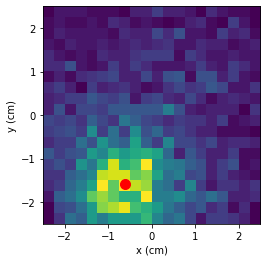

In [25]:
# check if data is ok
num = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(
    top[num], interpolation="nearest", origin="lower", extent=[-r, r, -r, r]
)
ax.imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-2.5, 2.5, -2.5, 2.5],
)
ax.plot(
    true_pos[num][0],
    true_pos[num][1],
    marker="o",
    markersize=10,
    color="red",
    label="true position",
)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

In [26]:
# create train and test sets
y = fine_top
X = top
pos = [pos[:2] for pos in true_pos]

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(
    X, y, pos, train_fraction=0.8
)

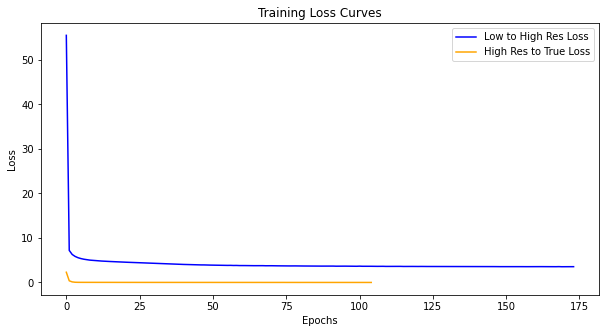

In [10]:
model1 = SuperResolutionModel(low_to_high_res_net_params=
    {"hidden_layer_sizes":(100,100),
    "activation":"relu", 
    "solver":"adam", 
    "alpha":0.0001, 
    "batch_size":"auto", 
    "learning_rate":"constant", 
    "learning_rate_init":0.001, 
    "power_t":0.5, 
    "max_iter":200, 
    "shuffle":True, 
    "random_state":None, 
    "tol":1e-4, 
    "verbose":False, 
    "warm_start":False, 
    "momentum":0.9, 
    "nesterovs_momentum":True, 
    "early_stopping":True, 
    "validation_fraction":0.1, 
    "beta_1":0.9, 
    "beta_2":0.999, 
    "epsilon":1e-8, 
    "n_iter_no_change":10, 
    "max_fun":15000}, 
    high_res_to_true_net_params=
    {"hidden_layer_sizes":(100,),
    "activation":"relu", 
    "solver":"adam", 
    "alpha":0.0001, 
    "batch_size":"auto", 
    "learning_rate":"constant", 
    "learning_rate_init":0.001, 
    "power_t":0.5, 
    "max_iter":200, 
    "shuffle":True, 
    "random_state":None, 
    "tol":1e-4, 
    "verbose":False, 
    "warm_start":False, 
    "momentum":0.9, 
    "nesterovs_momentum":True, 
    "early_stopping":True, 
    "validation_fraction":0.1, 
    "beta_1":0.9, 
    "beta_2":0.999, 
    "epsilon":1e-8, 
    "n_iter_no_change":10, 
    "max_fun":15000})
model1.train(X_train, y_train, pos_train)
model1.plot_loss_curve()

In [27]:
##########################
# SAVE-LOAD using pickle #
##########################
import pickle

# save
#with open('model1.pkl','wb') as f:
#    pickle.dump(model1,f)

# load
with open('model1.pkl', 'rb') as f:
    model1 = pickle.load(f)

In [28]:
def downsample_heatmaps_to_dimensions(heatmaps, new_height, new_width):
    """
    Downsample a list of heatmaps to specified dimensions using averaging.

    Args:
        heatmaps (list of numpy.ndarray): List of high-resolution heatmaps.
        new_height (int): The desired height of the downsampled heatmaps.
        new_width (int): The desired width of the downsampled heatmaps.

    Returns:
        list of numpy.ndarray: List of downsampled heatmaps.
    """
    downsampled_heatmaps = []

    for heatmap in heatmaps:
        # Get the dimensions of the original heatmap
        height, width = heatmap.shape

        # Reshape the heatmap to a 4D tensor for pooling
        heatmap_4d = heatmap.reshape((1, 1, height, width))

        # Calculate the scale factors for downsampling
        scale_factor_height = height // new_height
        scale_factor_width = width // new_width

        # Perform average pooling using np.mean
        downsampled_heatmap_4d = np.mean(heatmap_4d.reshape((1, 1, new_height, scale_factor_height, new_width, scale_factor_width)), axis=(3, 5))

        # Reshape the downsampled heatmap to the desired dimensions
        downsampled_heatmap = downsampled_heatmap_4d.reshape((new_height, new_width))

        downsampled_heatmaps.append(downsampled_heatmap)

    return np.asarray(downsampled_heatmaps)



In [29]:

y_train_downsampled = downsample_heatmaps_to_dimensions(y_train, 5, 5)
y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, 5, 5)
#y_train_downsampled_flattened = np.asarray(y_train_downsampled).reshape(y_train.shape[0], -1)
#y_test_downsampled_flattened = np.asarray(y_test_downsampled).reshape(y_test.shape[0], -1)

In [16]:

model2 = SuperResolutionModel()
model2.train(X_train, y_train_downsampled, pos_train)

/home/marjolein/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [35]:
##########################
# SAVE-LOAD using pickle #
##########################
import pickle

# save
#with open('model2.pkl','wb') as f:
 #   pickle.dump(model2,f)

# load
with open('model2.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [36]:
# Check the model
print(model1.evaluate(X_test, y_test, pos_test))
print(model2.evaluate(X_test, y_test_downsampled, pos_test))

{'MSE': 0.015142643871328665, 'R^2': 0.9941475275339946}
{'MSE': 0.008011055498109628, 'R^2': 0.9969038113737126}


In [60]:
# Create and train the single-step model
single_step_model = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=500)
single_step_model.fit(X_train.reshape(X_train.shape[0], -1), pos_train)

# Evaluate the single-step model
single_step_model_metrics = {
    'MSE': mean_squared_error(pos_test, single_step_model.predict(X_test.reshape(X_test.shape[0], -1))),
    'R^2': single_step_model.score(X_test.reshape(X_test.shape[0], -1), pos_test)
}
print(single_step_model_metrics)


{'MSE': 1.098186586805945, 'R^2': 0.5747133626734489}


In [67]:
def basic_prediction_low_res_with_origin_and_cell_size(low_res_heatmap, origin_x, origin_y, cell_size):
    """
    Compute a basic prediction for the true position using a weighted average of the low-resolution heatmap.

    Args:
        low_res_heatmap (numpy.ndarray): The low-resolution heatmap (2x2).
        origin_x (int): The x-coordinate of the origin (0,0) in the low-resolution heatmap.
        origin_y (int): The y-coordinate of the origin (0,0) in the low-resolution heatmap.
        cell_size (int): The size of each cell in the low-resolution heatmap.

    Returns:
        tuple: The predicted x and y coordinates.
    """
    # Define weights for each cell in the low-resolution heatmap
    weights = np.asarray([[1, 1], [1, 1]])  # Adjust weights as needed

    # Calculate the weighted sum for x and y coordinates
    weighted_sum_x = np.sum(low_res_heatmap * weights) / np.sum(low_res_heatmap)
    weighted_sum_y = np.sum(low_res_heatmap * weights.T) / np.sum(low_res_heatmap)

    # Adjust the prediction based on the position of the origin and cell size
    predicted_x = origin_x + (weighted_sum_x * cell_size)
    predicted_y = origin_y + (weighted_sum_y * cell_size)

    return predicted_x, predicted_y


In [70]:
basic_prediction_low_res_with_origin_and_cell_size(X_train[2],0, 0, 2.5)

(2.5, 2.5)

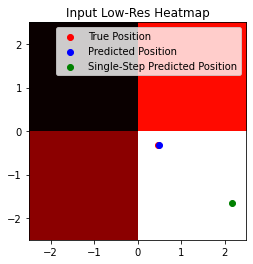

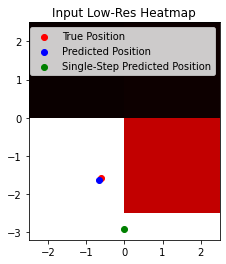

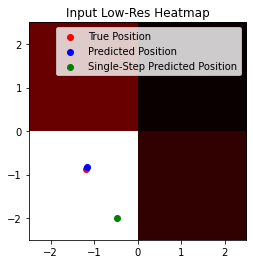

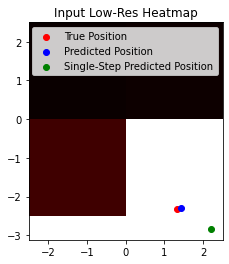

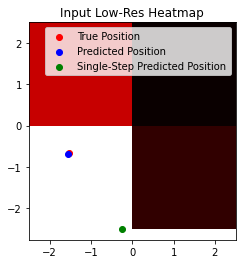

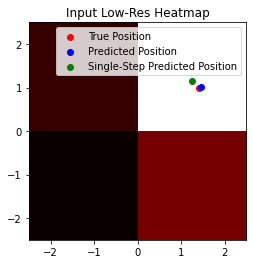

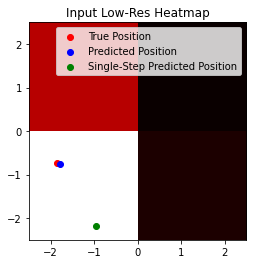

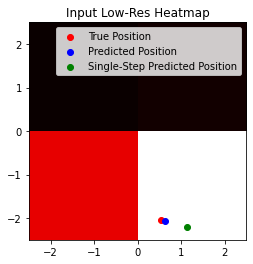

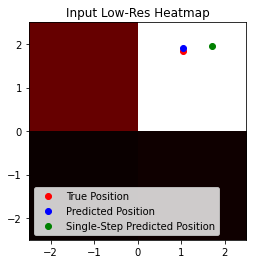

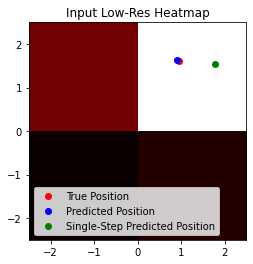

In [61]:
for i in range(10):
    plt.imshow(X_train[i], cmap='hot', interpolation='nearest', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
    plt.scatter(pos_train[i, 0], pos_train[i, 1], c='r', label='True Position')
    plt.scatter(*model2.predict(X_train)[i], marker='o', c='b', label='Predicted Position')
    plt.scatter(*single_step_model.predict(X_train.reshape(X_train.shape[0], -1))[i], marker='o', c='g', label='Single-Step Predicted Position')
    plt.title('Input Low-Res Heatmap')
    plt.legend()
    plt.show()

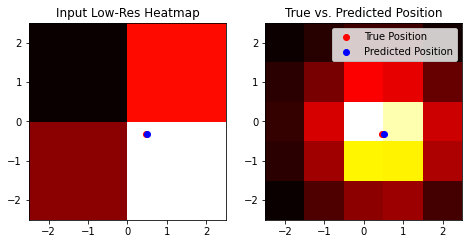

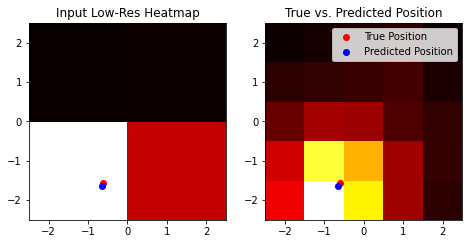

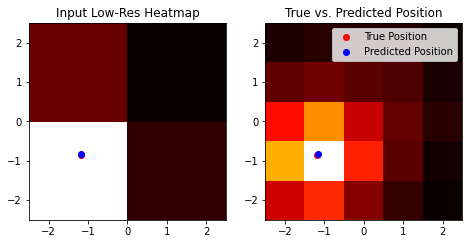

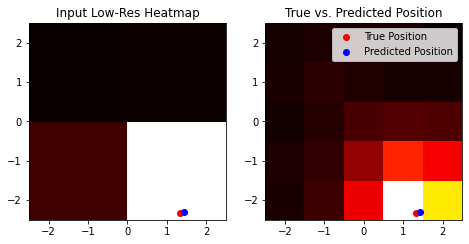

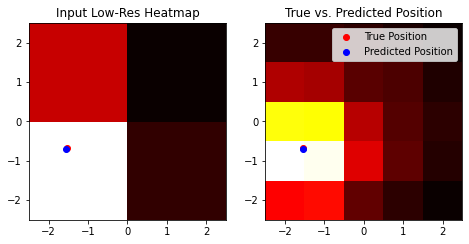

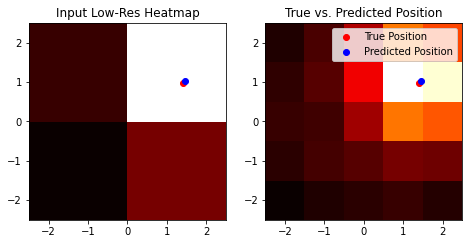

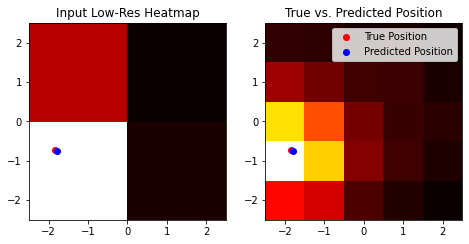

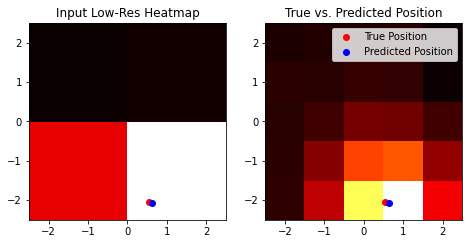

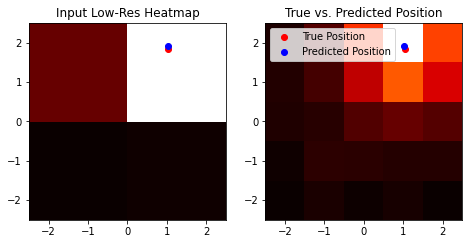

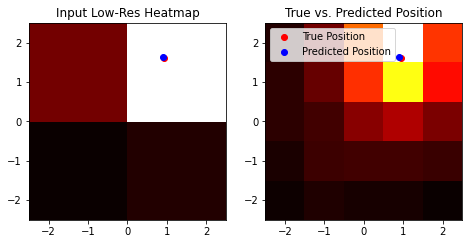

In [32]:
model2.visualize_heatmaps_with_positions(X_train, y_train_downsampled, pos_train)

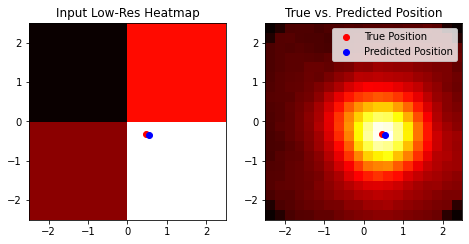

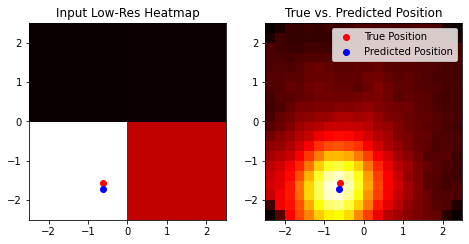

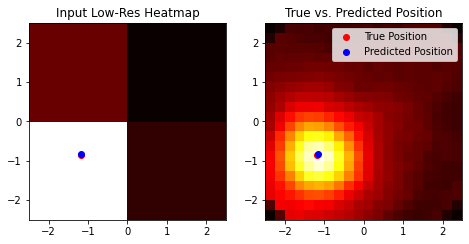

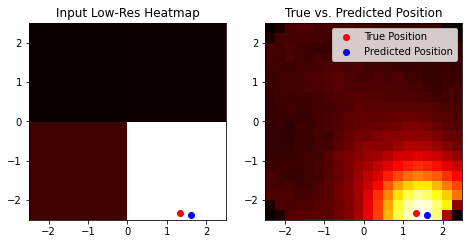

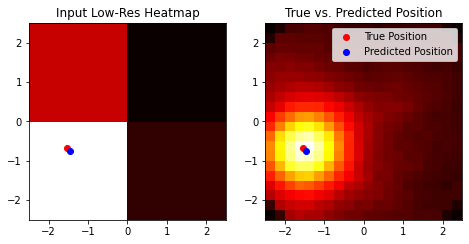

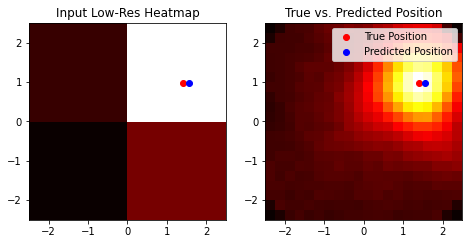

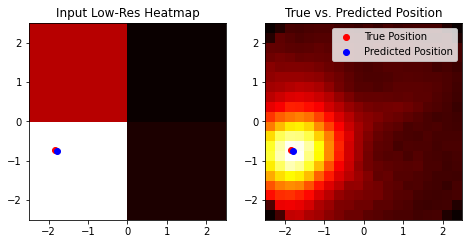

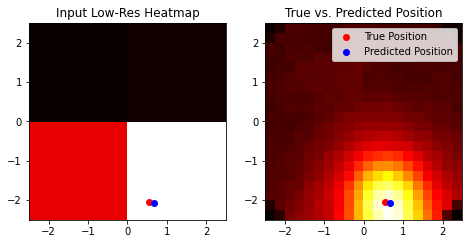

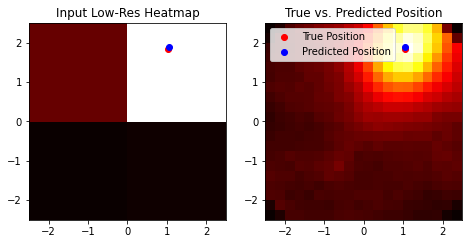

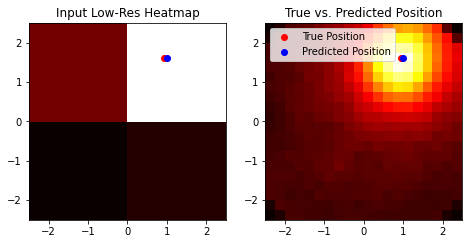

In [33]:
model1.visualize_heatmaps_with_positions(X_train, y_train, pos_train)

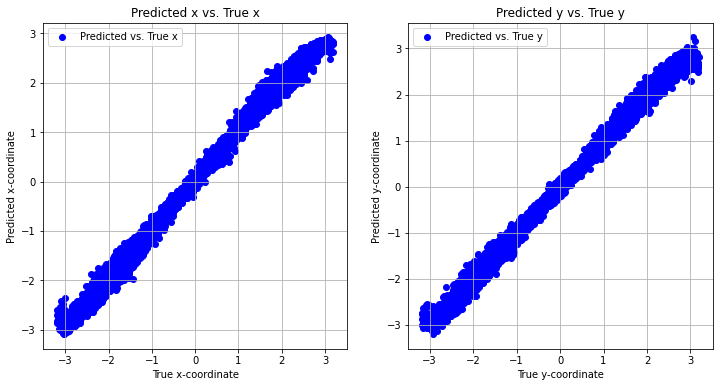

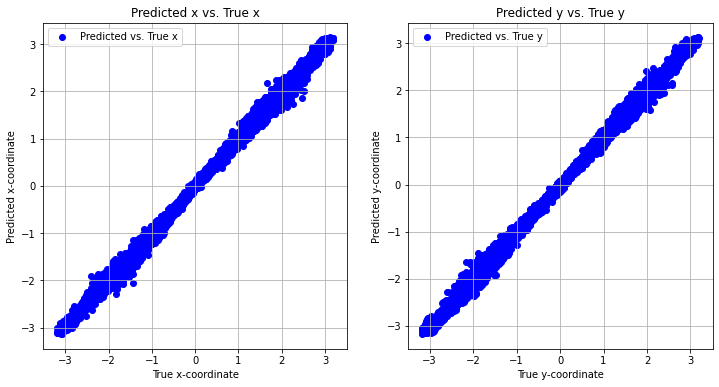

In [34]:
model1.visualize_x_vs_true_x(X_train, pos_train)
model2.visualize_x_vs_true_x(X_train, pos_train)

In [19]:
# train SUPER RESOLUTION MODEL
# Create and train the MLPRegressor model
model_sr = MLPRegressor(hidden_layer_sizes=(256, 124), activation='relu', solver='adam', random_state=42, early_stopping=True)
model_sr.fit(X_train_flattened, y_train_flattened)

# Evaluate the model
train_score = model_sr.score(X_train_flattened, y_train_flattened)
test_score = model_sr.score(X_test_flattened, y_test_flattened)

print('Training score:', train_score)
print('Testing score:', test_score)

NameError: name 'X_train_flattened' is not defined

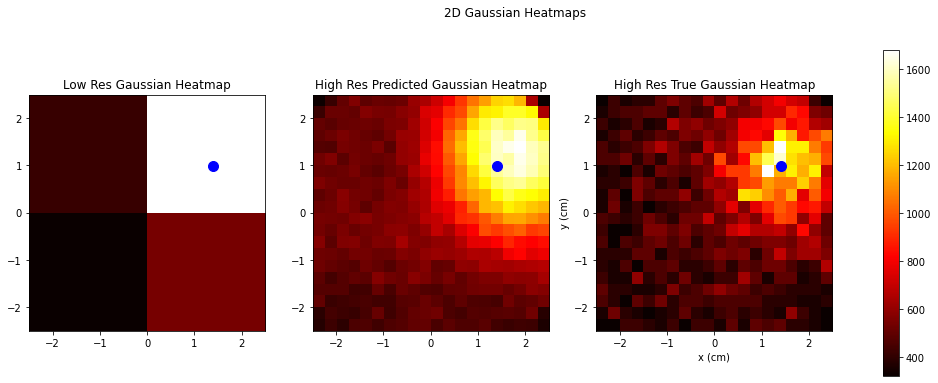

In [ ]:
def plot_res(num):
    # Plot the heatmap
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    im1 = ax[0].imshow(X_train_flattened[num].reshape((2,2)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
    ax[0].scatter(pos_train[num][0], pos_train[num][1], marker='o', color='blue', s=100)
    
    im2 = ax[1].imshow(model_sr.predict(X_train_flattened)[num].reshape((20,20)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
    ax[1].scatter(pos_train[num][0], pos_train[num][1], marker='o', color='blue', s=100)
    
    im3 = ax[2].imshow(y_train_flattened[num].reshape((20,20)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
    ax[2].scatter(pos_train[num][0], pos_train[num][1], marker='o', color='blue', s=100)
    
    # Create a colorbar object
    cbar = plt.colorbar(im1, ax=ax)

    ax[0].set_title('Low Res Gaussian Heatmap')
    ax[1].set_title('High Res Predicted Gaussian Heatmap')
    ax[2].set_title('High Res True Gaussian Heatmap')
    plt.suptitle('2D Gaussian Heatmaps')
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    plt.show()
plot_res(5)

In [ ]:
# HIGH RES TO POSITION MODEL

model_pos = MLPRegressor(hidden_layer_sizes=(256, 124), activation='relu', solver='adam', random_state=42, early_stopping=True)
model_pos.fit(y_train_flattened, pos_train_flattened)

# Evaluate the model
train_score = model_pos.score(y_train_flattened, pos_train_flattened)
test_score = model_pos.score(y_test_flattened, pos_test_flattened)
print('Training score:', train_score)
print('Testing score:', test_score)

Training score: 0.9780544815240464
Testing score: 0.8522673417387893


/home/marjolein/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
Predicted_pos = model_pos.predict(model_sr.predict(X_train_flattened))

IndexError: index 1301 is out of bounds for axis 0 with size 800

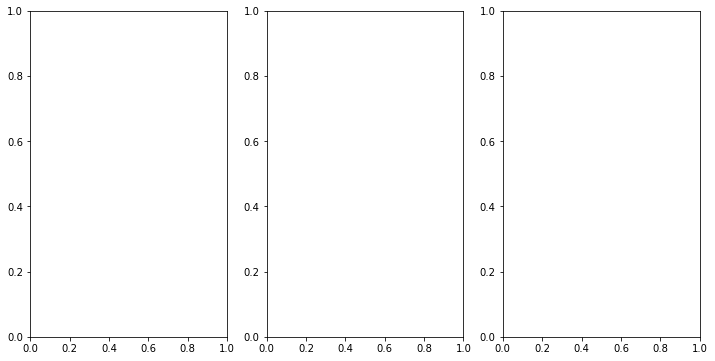

In [ ]:
num = 1301

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(y_train_flattened[num].reshape((20,20)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
ax[0].plot(Predicted_pos[num][0], Predicted_pos[num][1], c='black', marker = 'o', markersize=10, label='predicted position')
ax[0].plot(pos_train[num][0], pos_train[num][1], c='b', marker = 'x', markersize=10, label='true position')

ax[1].imshow(model_sr.predict(X_train_flattened)[num].reshape((20,20)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
ax[1].plot(Predicted_pos[num][0], Predicted_pos[num][1], c='black', marker = 'o', markersize=10, label='predicted position')
ax[1].plot(pos_train[num][0], pos_train[num][1], c='b', marker = 'x', markersize=10, label='true position')

ax[2].imshow(X_train_flattened[num].reshape((2,2)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
ax[2].plot(Predicted_pos[num][0], Predicted_pos[num][1], c='black', marker = 'o', markersize=10, label='predicted position')
ax[2].plot(pos_train[num][0], pos_train[num][1], c='b', marker = 'x', markersize=10, label='true position')

plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.show()


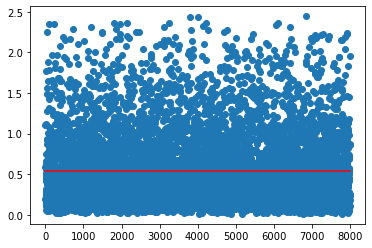

In [ ]:
avg_err = np.mean(np.linalg.norm(Predicted_pos-pos_train, axis=1))
errs = []
for num in range(8000):
    errs.append(np.linalg.norm(Predicted_pos[num]-pos_train[num]))

plt.scatter(range(8000), errs)
plt.plot([0,8000], [avg_err, avg_err], c='r')